In [1]:
import zipfile
import os


from sklearn.decomposition import PCA 
import tensorflow as tf
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
from sklearn.utils import shuffle
from skimage import filters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import pickle
# from google.colab import drive
# drive.mount('/content/drive')

# pca=pickle.load(open("/content/drive/MyDrive/Brain tumor detection/pca_model.sav",'rb'))
# final_model=pickle.load(open("/content/drive/MyDrive/Brain tumor detection/ensemble_model.sav",'rb'))
# model_cnn=pickle.load(open("/content/drive/MyDrive/Brain tumor detection/model_cnn2.sav",'rb'))



In [2]:
def show_before_and_after(before,after):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(before,plt.cm.gray)
    plt.title('Before')
    plt.subplot(1,2,2)
    plt.imshow(after,plt.cm.gray)
    plt.title('After')
    plt.show()


In [3]:
def convert_to_grayscale(image):
    gray_scale_img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return gray_scale_img

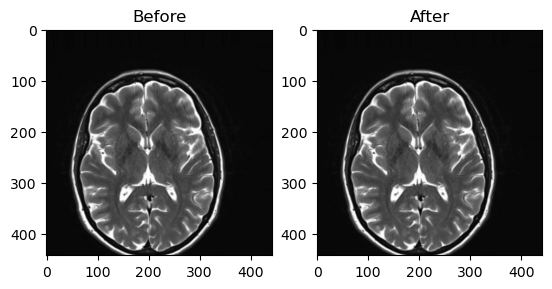

In [4]:
#Converting to gray scale 
sample_img=cv2.imread("E:/download/BTRIAL/aug/no/sath.jpg")
gray_scale_img_of_sample=convert_to_grayscale(sample_img)
show_before_and_after(sample_img,gray_scale_img_of_sample)


In [5]:
#Reduces image size and down sampling the image
def gaussian_blur(image):
    return cv2.GaussianBlur(image,(5,5),0)

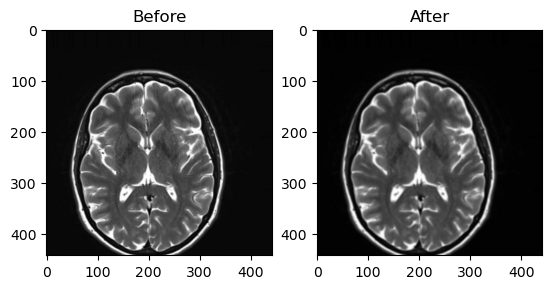

In [6]:
#Blurring the image
slightly_blurred_image=gaussian_blur(gray_scale_img_of_sample)
show_before_and_after(gray_scale_img_of_sample,slightly_blurred_image)

In [7]:
def threshold_image(image):
    ret,th=cv2.threshold(image,45,255,cv2.THRESH_BINARY)
    return th

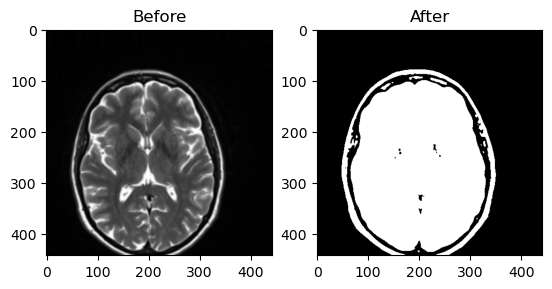

In [8]:
#Thresholding image
#A method of image segmentation which segments foreground from background
thresh_image=threshold_image(slightly_blurred_image)
#show_before_and_after(slightly_blurred_image,thresh_image)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(slightly_blurred_image,plt.cm.gray)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(thresh_image,plt.cm.gray)
plt.title('After')
plt.show()


In [9]:
def erode_image(image):
     return cv2.erode(image, None, iterations=2)
    

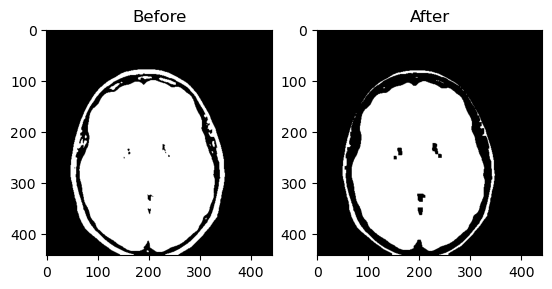

In [10]:
#Eroding image
#The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object
eroded_img=erode_image(thresh_image)

show_before_and_after(thresh_image,eroded_img)

In [11]:
def dilate_img(image):
    return cv2.dilate(image, None, iterations=2)

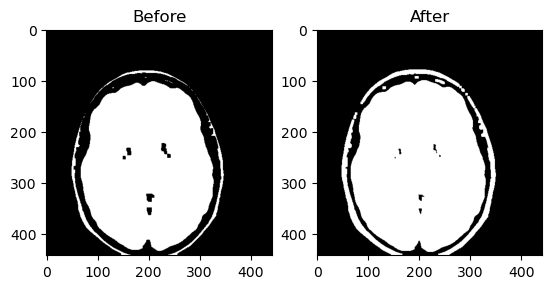

In [12]:
#Dilating image
#Dilation adds pixels to object boundaries
dilated_img=dilate_img(eroded_img)
show_before_and_after(eroded_img,dilated_img)

In [13]:
def crop_image_coordinates(image,plot=False):
    #Grabbing largest contours
    cntrs=cv2.findContours(image.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cntrs = imutils.grab_contours(cntrs)
    largest_cntr = max(cntrs, key=cv2.contourArea)
    #Extreme points finding for cropping
    ext_left = tuple(largest_cntr[largest_cntr[:, :, 0].argmin()][0])
    ext_right = tuple(largest_cntr[largest_cntr[:, :, 0].argmax()][0])
    ext_top = tuple(largest_cntr[largest_cntr[:, :, 1].argmin()][0])
    ext_bot = tuple(largest_cntr[largest_cntr[:, :, 1].argmax()][0])
    return [ext_left,ext_right,ext_top,ext_bot]
    

In [14]:
def crop_image(image,crop_image_coords):
    return image[crop_image_coords[2][1]:crop_image_coords[3][1], crop_image_coords[0][0]:crop_image_coords[1][0]]

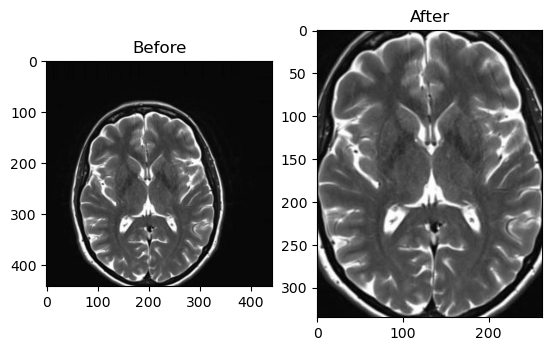

In [15]:
#Cropping only the brain image
coords=crop_image_coordinates(dilated_img)
cropped_image=crop_image(sample_img,coords)
show_before_and_after(sample_img,cropped_image)

In [16]:
def resize_image(image,size):
    width,height=size
    return cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)


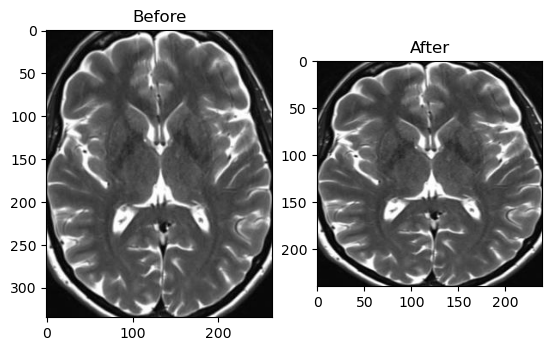

In [17]:
#Resizing image
resized_image=resize_image(cropped_image,[240,240])
show_before_and_after(cropped_image,resized_image)

In [18]:
def normalize_image(image):
    return image/255


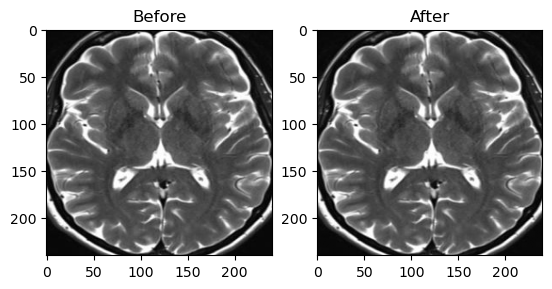

In [19]:
#Normalizing image
normalized_image=normalize_image(resized_image)
show_before_and_after(resized_image,normalized_image)

In [20]:
def prepare_image(image):
    return normalize_image(resize_image
    (crop_image(image,crop_image_coordinates
    (dilate_img(erode_image(threshold_image
    (gaussian_blur(convert_to_grayscale(image))))))),[240,240]))



In [21]:

# Performing above steps on the whole dataset
def load_data(directory_list, image_size):

    # load all images in a directory
    Image = []
    label = []
    width, height = image_size
    
    for directory in directory_list:
        for filename in os.listdir(directory):
            #load the image
            
            image = cv2.imread(directory + '/' + filename)
            image = prepare_image(image)
            Image.append(image)
            # append a value of 1 to the label array if the image
            # is in the folder named 'yes', else append 0.
            if directory[-3:] == 'yes':
                label.append([1])
            else:
                label.append([0])
                
    Image = np.array(Image)
    label = np.array(label)
    
    # Shuffle the data
    Image, label = shuffle(Image, label)
    
    
    
    return Image, label

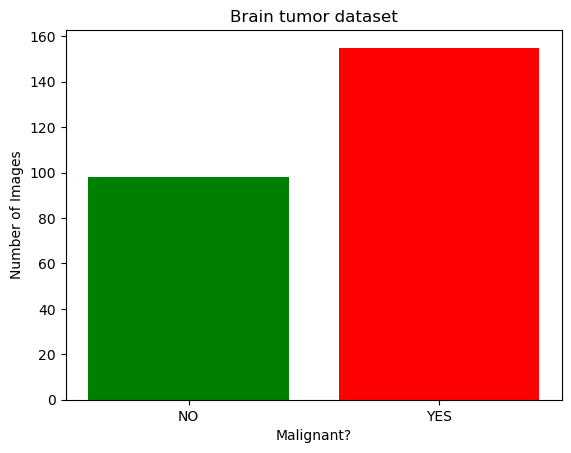

In [22]:
#Visualization1 - Number of benign and malignant tumor scans
data_path=r'E:/download/BTRIAL/Brain-tumor-datasets-master/'
data_path_yes=data_path+'yes'
data_path_no=data_path+'no'
width,height=(240,240)
Image,label=load_data([data_path_yes,data_path_no],[width,height])
label_list=label.tolist()
no_yes_count=[0,0]
for i in range(len(label_list)):
    no_yes_count[label_list[i][0]]+=1
xaxis=["NO","YES"]
yaxis=no_yes_count
plt.figure()
plt.bar(xaxis,yaxis,color=['green','red'])
plt.xlabel("Malignant?")
plt.ylabel("Number of Images")
plt.title("Brain tumor dataset")
plt.show()



In [23]:

#Visualization2- Histogram of gray scale intensity
yes_img=cv2.imread("E:/download/BTRIAL/aug/no/aug_no_0_6818.jpg")
no_img=cv2.imread("E:/download/BTRIAL/aug/no/aug_no_0_6818.jpg")
yes_img=convert_to_grayscale(yes_img)
no_img=convert_to_grayscale(no_img)
histg_yes = cv2.calcHist([yes_img],[0],None,[256],[0,256])
histg_no = cv2.calcHist([no_img],[0],None,[256],[0,256])
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(histg_yes)
plt.xlabel("Gray Scale Value")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Gray Values in a random scan with Brain tumor")
plt.subplot(1,2,2)
plt.xlabel("Gray Scale Value")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Gray Values in a random scan without Brain tumor")

plt.plot(histg_no)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [24]:
#Visualization3 -Detecting Edges

edges_of_image_yes = filters.sobel(yes_img)
edges_of_image_no = filters.sobel(no_img)

plt.figure(figsize=[15,15])
plt.subplot(2,2,1)
plt.imshow(yes_img,plt.cm.gray)
plt.title("Image with brain tumor")
plt.subplot(2,2,2)
plt.title("Edge detection of Image with brain tumor")
plt.imshow(edges_of_image_yes,plt.cm.gray)


plt.subplot(2,2,3)
plt.imshow(no_img,plt.cm.gray)
plt.title("Image without brain tumor")
plt.subplot(2,2,4)
plt.title("Edge detection of Image without brain tumor")
plt.imshow(edges_of_image_no,plt.cm.gray)

plt.show()




AttributeError: 'NoneType' object has no attribute 'ndim'

In [25]:
Image.shape

(253, 240, 240, 3)

In [26]:
l=[]
for image_no in range((Image.shape)[0]):
    l.append(Image[image_no].ravel())
df=pd.DataFrame(l,columns=[i for i in range(len(l[0]))])
df["Target"]=label
df.head()

,0,1,2,3,4,5,6,7,8,9,...,172791,172792,172793,172794,172795,172796,172797,172798,172799,Target
0,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,1
1,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0
2,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0
3,0.192157,0.188235,0.172549,0.192157,0.188235,0.172549,0.196078,0.192157,0.176471,0.196078,...,0.192157,0.188235,0.172549,0.192157,0.188235,0.172549,0.192157,0.188235,0.172549,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [27]:

X=df[df.columns[0:-1]]
y=df['Target']


In [28]:
#Train and test split
X_train,X_test,Y_train,Y_test=train_test_split(X, y, test_size = 0.2)
X_train


,0,1,2,3,4,5,6,7,8,9,...,172790,172791,172792,172793,172794,172795,172796,172797,172798,172799
178,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.007843,...,0.007843,0.007843,0.007843,0.007843,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765
90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
171,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
101,0.007843,0.007843,0.007843,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,...,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
150,0.094118,0.094118,0.094118,0.094118,0.094118,0.094118,0.094118,0.094118,0.094118,0.094118,...,0.098039,0.101961,0.101961,0.101961,0.094118,0.094118,0.094118,0.082353,0.082353,0.082353
85,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.015686,...,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019608,0.039216,0.039216,0.039216,0.054902,0.054902,0.054902,0.062745,0.062745,0.062745


In [29]:
pca = PCA(n_components = 202)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [30]:
#Limited memory Broyden–Fletcher–Goldfarb–Shanno
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(32,16,8,4,2), random_state=0)
clf.fit(X_train, Y_train)
y_pred=clf.predict(X_test)
confusion_matrix(Y_test,y_pred)
mlp_acc=accuracy_score(Y_test,y_pred)

In [31]:
model_svm=svm.SVC()
model_svm.fit(X_train,Y_train)
y_pred=model_svm.predict(X_test)
confusion_matrix(Y_test,y_pred)
svm_acc=accuracy_score(Y_test,y_pred)


In [32]:
dtree=DecisionTreeClassifier(max_depth=10,random_state=0)
model=dtree.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
dtree_acc=accuracy_score(Y_test,y_pred)

In [33]:
rtree=RandomForestClassifier(n_estimators=128,random_state=0)
model=rtree.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
rtree_acc=accuracy_score(Y_test,y_pred)

In [34]:
lr=LogisticRegression(max_iter=250)
model=lr.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
lr_acc=accuracy_score(Y_test,y_pred)

In [35]:
xc=XGBClassifier()
model=xc.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
xc_acc=accuracy_score(Y_test,y_pred)

In [36]:
model_1 = XGBClassifier()
model_2 = LogisticRegression(max_iter=200)
model_3 = svm.SVC(kernel="poly",probability=True)
model_4=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(64,32,16,8,4,2), random_state=0)
model_5=svm.SVC(kernel="rbf",probability=True)
final_model = VotingClassifier(estimators=[('XGB', model_1), ('LR', model_2), ('svm1', model_3),('MLP',model_4),('svm2',model_5)], voting='hard')
final_model.fit(X_train,Y_train)
y_pred=final_model.predict(X_test)
confusion_matrix(Y_test,y_pred)
ensem_acc=accuracy_score(Y_test,y_pred)

y_pred=final_model.predict(X_test)
ensem_acc=accuracy_score(Y_test,y_pred)

In [37]:
ensem_acc

0.6666666666666666

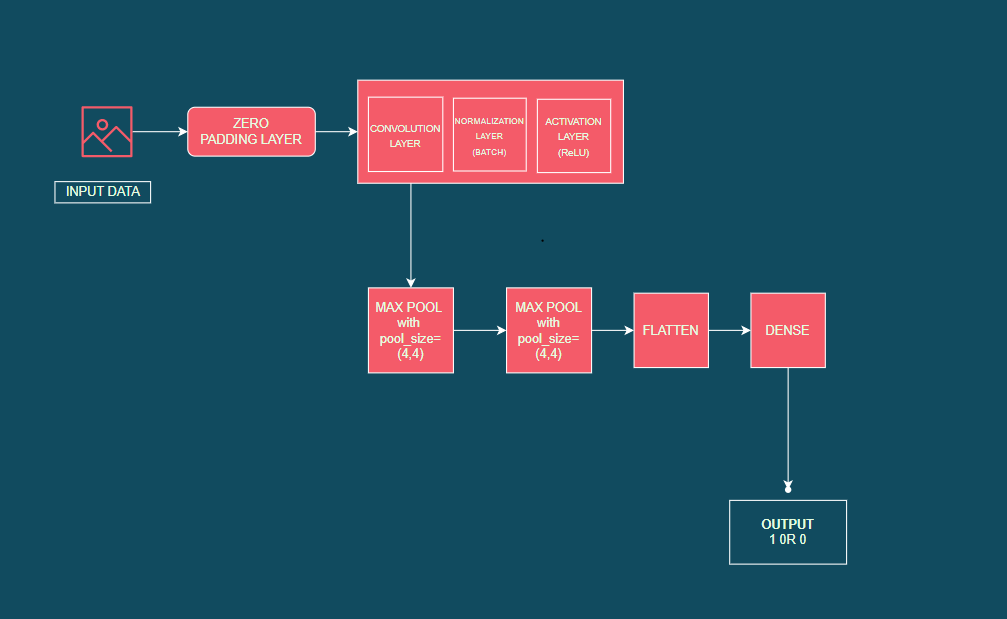

In [38]:
def build_model(input_shape):
    
     
    X_input = Input(input_shape)
    
    #Padding zeroes to the input
    X = ZeroPadding2D((2, 2))(X_input) 
    
    #Convolution
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    #Batch Normalization
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    #ACtivation Function-Relu(Rectified Linear Unit)
    X = Activation('relu')(X)
    #Pooling with max value
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  
    #Pooling with max value
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    #Converting the higher dimensional data to 1D data
    X = Flatten()(X)
    #Creating a dense fully connected neural network
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    #Creating instance of keras model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [39]:
X_train_,X_test_,Y_train_,Y_test_=train_test_split(Image, label, test_size = 0.2, random_state = 6)
model_cnn=build_model((240,240,3))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(x=X_train_, y=Y_train_)

7/7 [==============================] - 14s 2s/step - loss: 1.8743 - accuracy: 0.5644


In [40]:
X_train_,X_test_,Y_train_,Y_test_=train_test_split(Image, label, test_size = 0.2, random_state = 6)


In [41]:
loss, cnn_acc = model_cnn.evaluate(x=X_train_, y=Y_train_)

7/7 [==============================] - 3s 350ms/step - loss: 0.6589 - accuracy: 0.6337


In [42]:
cnn_acc

0.6336633563041687

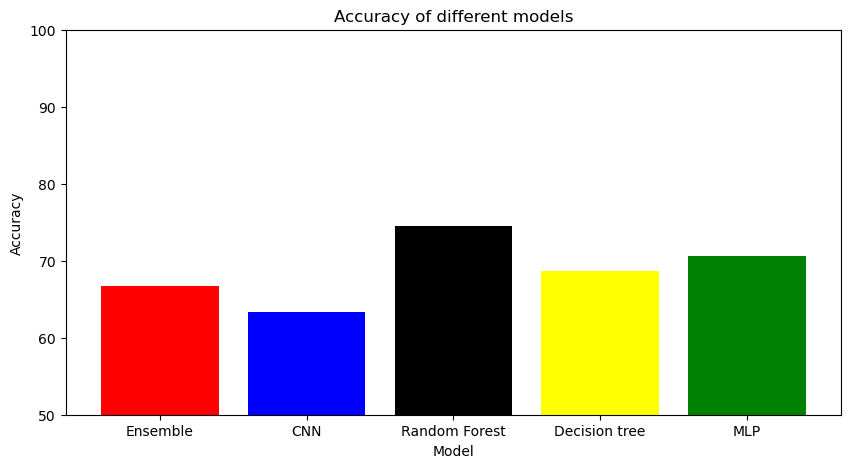

In [43]:
xaxis=["Ensemble","CNN","Random Forest","Decision tree","MLP"]
yaxis=[ensem_acc*100,cnn_acc*100,rtree_acc*100,dtree_acc*100,mlp_acc*100]
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color=['red','blue','black','yellow','green'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of different models")
plt.ylim([50,100])
plt.show()


In [44]:
yaxis

[66.66666666666666,
 63.36633563041687,
 74.50980392156863,
 68.62745098039215,
 70.58823529411765]

In [ ]:
 def displayTumor(self):
        sure_bg = cv.dilate(self.curImg, self.kernel, iterations=3)
        dist_transform = cv.distanceTransform(self.curImg, cv.DIST_L2, 5)
        ret, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv.subtract(sure_bg, sure_fg)
        ret, markers = cv.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        markers = cv.watershed(self.Img, markers)
        self.Img[markers == -1] = [255, 0, 0]
        tumorImage = cv.cvtColor(self.Img, cv.COLOR_HSV2BGR)
        self.curImg = tumorImage